https://raw.githubusercontent.com/fchollet/keras/master/examples/cifar10_cnn.py

Train a simple deep CNN on the CIFAR10 small images dataset.

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from datetime import datetime


Using TensorFlow backend.


In [2]:
from keras import backend as K
import os

#https://keras.io/backend/

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        K.set_image_dim_ordering('th')
        reload(K)
        assert K.backend() == backend

set_keras_backend("theano")


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [3]:
batch_size = 64
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
print ("save_dir:", save_dir)

save_dir: /home/ubuntu/fastai/miscLearning/saved_models


In [4]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples', x_train.shape)
print(x_test.shape[0], 'test samples', x_test.shape)


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples (50000, 32, 32, 3)
10000 test samples (10000, 32, 32, 3)


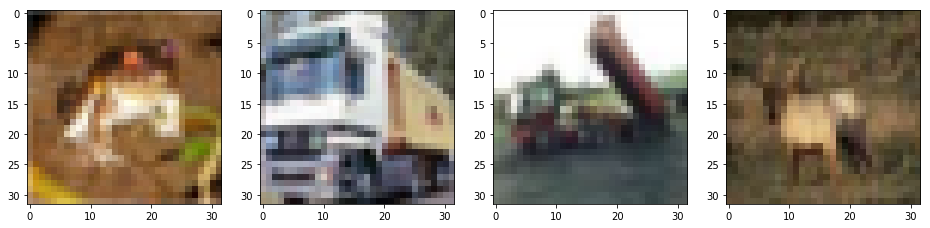

In [5]:
f, axarr = plt.subplots(1,4,figsize=(16,16))

for i in range(0,4):
    axarr[i].imshow(x_train[i])


In [6]:
print ("before conversion to binary class matrices")
print ("y_train:", y_train.shape, y_train[0])
print ("y_test:", y_test.shape, y_test[0])

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print ("after conversion to binary class matrices")
print ("y_train:", y_train.shape, y_train[0])
print ("y_test:", y_test.shape, y_test[0])


before conversion to binary class matrices
y_train: (50000, 1) [6]
y_test: (10000, 1) [3]
after conversion to binary class matrices
y_train: (50000, 1, 10) [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
y_test: (10000, 1, 10) [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print (type(model))
print (type(model.layers), len(model.layers))

<class 'keras.models.Sequential'>
<type 'list'> 18


In [8]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [9]:
startTime= datetime.now()
print ("start")
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

start
Time elpased (hh:mm:ss.ms) 0:00:00.161784


In [10]:
#convert from int to float32 & convert range from 0-255 to 0-1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [11]:


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, categorical_crossentropy,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    #https://keras.io/preprocessing/image/
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)


Using real-time data augmentation.


ValueError: Error when checking target: expected activation_6 to have 2 dimensions, but got array with shape (10000, 1, 10)